In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [ ]:
!pip install shap

Ранее с помощью PyCaret был проведен автоматизированированный подбор моделей, по его результатам отобраны три наиболее перспективных алгоритма: **CatBoost**, **XGBoost** и **Random Forest**. Из этих трёх моделей наилучшие метрики показал **XGBoost**, поэтому он был выбран в качестве базовой модели для дальнейшей работы (предыдущий шаг).  

---

## Реализация стекинга

На данном этапе предстоит реализовать различные варианты стекинга, чтобы объединить сильные стороны всех трёх алгоритмов и получить ещё более устойчивые и точные предсказания. Гиперпараметры для этих моделей найдены с помощью PyCaret на предыдущем шаге и будут использованы для моделей в экспериментах.

### 1. Попарный стекинг

### Подход:
- Провести три отдельных эксперимента для следующих пар:
  1. CatBoost + XGBoost  
  2. CatBoost + Random Forest  
  3. XGBoost + Random Forest  
- В качестве мета-алгоритма использовать лёгкую логистическую регрессию или небольшой GBM с регуляризацией.
- Оценить прирост качества по метрикам.

### 2. Стекинг всех трёх моделей

### Подход:
- На вход мета-уровня подать предсказания сразу от **CatBoost**, **XGBoost** и **Random Forest** вместе.  
- Выбрать регуляризованную модель (логистическая регрессия, LightGBM с небольшими деревьями) в качестве мета-алгоритма.  
- Оценить прирост качества по метрикам.

---


Таким образом, **попарный стекинг** позволит быстро определить наиболее перспективные сочетания моделей, а **полный стекинг из трёх** покажет, насколько эффективно можно объединить их сильные стороны для продакшен-решения.  


## Результаты обучения модели XGBoost с учетом дисбаланса классов

На предыдущем этапе была обучена модель **XGBoost** с учетом дисбаланса классов. Для корректировки влияния классов использован параметр `scale_pos_weight`, значение которого было вычислено как отношение количества объектов отрицательного класса к количеству объектов положительного класса.

Такой подход позволяет модели уделять больше внимания меньшинственному классу в процессе обучения. Ниже приведены полученные метрики:

| Класс | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.81      | 0.54   | 0.65     | 5507    |
| 1     | 0.50      | 0.78   | 0.61     | 3201    |
| **Accuracy**     | —        | —      | **0.63**   | 8708    |
| **Macro avg**    | 0.65     | 0.66   | 0.63     | 8708    |
| **Weighted avg** | 0.69     | 0.63   | 0.63     | 8708    |


В дальнейшем при обучении моделей будет сохраняться подход к учёту дисбаланса классов - настройка параметра `scale_pos_weight` или другие техники, направленные на устранение дисбаланса.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Определяем заново датасет, чтобы ничего не потерять
df_1st = pd.read_csv('df_full43875k.csv', sep=',', index_col=0)#
df_1st = df_1st.drop(columns=['index', 'lat_x', 'lon_x', 'dt_x', 'dt_y', 'lat_y', 'lon_y', 'lat_group', 'lon_group', 'group_id', 'type_name', 'type_id'])
df_1st = df_1st[df_1st['wind_gusts_10m_max'] <= 70]
df_1st = df_1st[(df_1st['precipitation_sum'] < 50) | (df_1st['rain_sum'] < 50)]
df_1st['date'] = pd.to_datetime(df_1st['date'])
df_1st = df_1st.drop(columns=['type', 'sunrise', 'sunset', 'year'])

<ipython-input-2-f103f0be2ae1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1st['date'] = pd.to_datetime(df_1st['date'])


In [ ]:
df_1st.columns

Index(['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
       'apparent_temperature_max', 'apparent_temperature_min',
       'apparent_temperature_mean', 'precipitation_sum', 'rain_sum',
       'snowfall_sum', 'precipitation_hours', 'relative_humidity_2m_max',
       'relative_humidity_2m_min', 'relative_humidity_2m_mean',
       'dew_point_2m_max', 'dew_point_2m_min', 'dew_point_2m_mean',
       'wind_speed_10m_max', 'wind_speed_10m_min', 'wind_speed_10m_mean',
       'wind_gusts_10m_max', 'wind_gusts_10m_mean',
       'wind_direction_10m_dominant', 'sunshine_duration', 'daylight_duration',
       'shortwave_radiation_sum', 'pressure_msl_max', 'pressure_msl_min',
       'pressure_msl_mean', 'weather_code', 'et0_fao_evapotranspiration',
       'date', 'lat', 'lon', 'label'],
      dtype='object')

## После вывода метрик каждый раз будем сравнивать с одиночной моделью XGBoost

## CatBoost + XGBoost

In [ ]:
from sklearn.ensemble import StackingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df_xgb = df_1st.sort_values('date').reset_index(drop=True)
X = df_xgb.drop(columns=['label', 'date'])
y = df_xgb['label']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]


xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method': 'auto',
    'learning_rate': 0.25,
    'max_depth': 5,
    'subsample': 0.51,
    'colsample_bytree': 0.72,
    'reg_lambda': 0.93,
    'reg_alpha': 1.62,
    'n_estimators': 763,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}

cb_params = {
    'nan_mode': 'Min',
    'eval_metric': 'Logloss',
    'iterations': 1000,
    'sampling_frequency': 'PerTree',
    'leaf_estimation_method': 'Newton',
    'random_score_type': 'NormalWithModelSizeDecrease',
    'grow_policy': 'SymmetricTree',
    'penalties_coefficient': 1,
    'boosting_type': 'Plain',
    'model_shrink_mode': 'Constant',
    'feature_border_type': 'GreedyLogSum',
    'eval_fraction': 0,
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'rsm': 1,
    'boost_from_average': False,
    'model_size_reg': 0.5,
    'subsample': 0.800000011920929,
    'use_best_model': False,
    'class_names': [0, 1],
    'random_seed': 42,
    'depth': 6,
    'posterior_sampling': False,
    'border_count': 254,
    'classes_count': 0,
    'auto_class_weights': 'None',
    'sparse_features_conflict_fraction': 0,
    'leaf_estimation_backtracking': 'AnyImprovement',
    'best_model_min_trees': 1,
    'model_shrink_rate': 0,
    'min_data_in_leaf': 1,
    'loss_function': 'Logloss',
    'learning_rate': 0.044870998710393906,
    'score_function': 'Cosine',
    'task_type': 'CPU',
    'leaf_estimation_iterations': 10,
    'bootstrap_type': 'MVS',
    'max_leaves': 64,
    'auto_class_weights': 'Balanced'
}



xgb_clf = XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss')
cb_clf = CatBoostClassifier(**cb_params)


meta_models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='liblinear',
            max_iter=1000,
            class_weight={0: 1, 1: scale_pos_weight},
            random_state=42
        ))
    ]),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        class_weight='balanced',
        random_state=42
    ),
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=100,
        max_depth=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
}

cv = KFold(n_splits=5, shuffle=False)

for name, meta_model in meta_models.items():
    print(f"\n=== Meta-model: {name} ===")

    stacking_clf = StackingClassifier(
        estimators=[
            ('xgb', xgb_clf),
            ('cb', cb_clf)
        ],
        final_estimator=meta_model,
        cv=cv,
        passthrough=False,
        n_jobs=-1
    )

    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))


=== Meta-model: LogisticRegression ===
              precision    recall  f1-score   support

           0      0.863     0.474     0.612      5507
           1      0.490     0.870     0.627      3201

    accuracy                          0.620      8708
   macro avg      0.676     0.672     0.620      8708
weighted avg      0.726     0.620     0.617      8708


=== Meta-model: LightGBM ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8686, number of negative: 26143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 34829, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.914     0.398     0.554      5507
           1      0.475     0.936     0.630      3201

    accuracy                          0.596      8708
   macro avg      0.694     0.667     0.592      8708
weighted avg      0.753     0.596     0.582      8708


=== Meta-model: ExtraTrees ===
              precision    recall  f1-score   support

           0      0.908     0.392     0.548      5507
           1      0.471     0.932     0.626      3201

    accuracy                          0.590      8708
   macro avg      0.690     0.662     0.587      8708
weighted avg      0.748     0.590     0.576      8708



По итогам одиночный XGBoost дал самый ровный результат (accuracy ≈ 0.63, средний F1 ≈ 0.63). Вариант со стекингом и логистической регрессией чуть лучше ловит редкий класс 1, но чуть хуже работает с классом 0, а стекинги на LightGBM и ExtraTrees ещё сильнее смещаются в пользу класса 1 и в целом показывают меньшую точность. Для общего балансаможно использовать XGBoost, а если важно не пропускать класс 1 — использовать стекинг.

Также был проведён эксперимент с passthrough=True (передача исходных признаков вместе с мета-признаками в мета-модель), который показал худшие результаты по сравнению с passthrough=False


## XGBoost + Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

df_xgb = df_1st.sort_values('date')

X = df_xgb.drop(columns=['label', 'date'])
y = df_xgb['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]

xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'learning_rate': 0.25,
    'max_depth': 5,
    'subsample': 0.51,
    'colsample_bytree': 0.72,
    'reg_lambda': 0.93,
    'reg_alpha': 1.62,
    'n_estimators': 763,
    'random_state': 42,
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': 0
}

rf_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'monotonic_cst': None,
    'n_estimators': 100,
    'n_jobs': -1,
    'oob_score': False,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False,
    'class_weight': {0:1, 1:scale_pos_weight}#'balanced'
}

ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_clf = XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss')
rf_clf = RandomForestClassifier(**rf_params)

meta_models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='liblinear',
            max_iter=1000,
            class_weight={0: 1, 1: scale_pos_weight},
            random_state=42
        ))
    ]),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        class_weight='balanced',
        random_state=42
    ),
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=100,
        max_depth=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
}

cv = KFold(n_splits=5, shuffle=False)

for name, meta_model in meta_models.items():
    print(f"\n=== Meta-model: {name} ===")

    stacking_clf = StackingClassifier(
        estimators=[
        ('xgb', xgb_clf),
        ('rf',  rf_clf)
        ],
        final_estimator=meta_model,
        cv=cv,
        passthrough=False,
        n_jobs=-1
    )

    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))


=== Meta-model: LogisticRegression ===
              precision    recall  f1-score   support

           0      0.824     0.518     0.636      5507
           1      0.494     0.809     0.613      3201

    accuracy                          0.625      8708
   macro avg      0.659     0.664     0.625      8708
weighted avg      0.702     0.625     0.628      8708


=== Meta-model: LightGBM ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8686, number of negative: 26143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 34829, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.905     0.401     0.555      5507
           1      0.474     0.927     0.627      3201

    accuracy                          0.594      8708
   macro avg      0.689     0.664     0.591      8708
weighted avg      0.746     0.594     0.582      8708


=== Meta-model: ExtraTrees ===
              precision    recall  f1-score   support

           0      0.896     0.411     0.563      5507
           1      0.475     0.918     0.626      3201

    accuracy                          0.597      8708
   macro avg      0.686     0.664     0.595      8708
weighted avg      0.741     0.597     0.587      8708



Одиночный XGBoost лучше всего держит баланс между классами по точности и F1, тогда как стекинги с Random Forest лишь улучшают обнаружение класса 1, но сильно ухудшают распознавание класса 0 и общую точность. То есть, если важен равномерный результат для обоих классов — подходит XGBoost, а если нужно не пропустить положительные случаи, можно использовать стекинг с LightGBM или ExtraTrees.

Также был проведён эксперимент с passthrough=True (передача исходных признаков вместе с мета-признаками в мета-модель), который показал худшие результаты по сравнению с passthrough=False

## CatBoost + Random Forest

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

df_xgb = df_1st.sort_values('date')

X = df_xgb.drop(columns=['label', 'date'])
y = df_xgb['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]

rf_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'monotonic_cst': None,
    'n_estimators': 100,
    'n_jobs': -1,
    'oob_score': False,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False,
    'class_weight': {0:1, 1:scale_pos_weight}#'balanced'
}

cb_params = {
    'nan_mode': 'Min',
    'eval_metric': 'Logloss',
    'iterations': 1000,
    'sampling_frequency': 'PerTree',
    'leaf_estimation_method': 'Newton',
    'random_score_type': 'NormalWithModelSizeDecrease',
    'grow_policy': 'SymmetricTree',
    'penalties_coefficient': 1,
    'boosting_type': 'Plain',
    'model_shrink_mode': 'Constant',
    'feature_border_type': 'GreedyLogSum',
    'eval_fraction': 0,
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'rsm': 1,
    'boost_from_average': False,
    'model_size_reg': 0.5,
    'subsample': 0.800000011920929,
    'use_best_model': False,
    'class_names': [0, 1],
    'random_seed': 42,
    'depth': 6,
    'posterior_sampling': False,
    'border_count': 254,
    'classes_count': 0,
    'auto_class_weights': 'None',
    'sparse_features_conflict_fraction': 0,
    'leaf_estimation_backtracking': 'AnyImprovement',
    'best_model_min_trees': 1,
    'model_shrink_rate': 0,
    'min_data_in_leaf': 1,
    'loss_function': 'Logloss',
    'learning_rate': 0.044870998710393906,
    'score_function': 'Cosine',
    'task_type': 'CPU',
    'leaf_estimation_iterations': 10,
    'bootstrap_type': 'MVS',
    'max_leaves': 64,
    'auto_class_weights': 'Balanced'
}


rf_clf = RandomForestClassifier(**rf_params)
cb_clf  = CatBoostClassifier(**cb_params, verbose=0)

meta_models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='liblinear',
            max_iter=1000,
            class_weight={0: 1, 1: scale_pos_weight},
            random_state=42
        ))
    ]),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        class_weight='balanced',
        random_state=42
    ),
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=100,
        max_depth=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
}

cv = KFold(n_splits=5, shuffle=False)

for name, meta_model in meta_models.items():
    print(f"\n=== Meta-model: {name} ===")

    stacking_clf = StackingClassifier(
        estimators=[
        ('rf',  rf_clf),
        ('cb',  cb_clf)
        ],
        final_estimator=meta_model,
        cv=cv,
        passthrough=False,
        n_jobs=-1
    )

    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))


=== Meta-model: LogisticRegression ===
              precision    recall  f1-score   support

           0      0.862     0.485     0.621      5507
           1      0.494     0.867     0.630      3201

    accuracy                          0.625      8708
   macro avg      0.678     0.676     0.625      8708
weighted avg      0.727     0.625     0.624      8708


=== Meta-model: LightGBM ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8686, number of negative: 26143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 34829, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.907     0.404     0.559      5507
           1      0.475     0.928     0.629      3201

    accuracy                          0.597      8708
   macro avg      0.691     0.666     0.594      8708
weighted avg      0.748     0.597     0.585      8708


=== Meta-model: ExtraTrees ===
              precision    recall  f1-score   support

           0      0.919     0.387     0.544      5507
           1      0.472     0.942     0.628      3201

    accuracy                          0.591      8708
   macro avg      0.695     0.664     0.586      8708
weighted avg      0.755     0.591     0.575      8708



CatBoost и Random Forest в стекинге начинает отдавать приоритет классу 1: с LogisticRegression-мета recall класса 1 вырастает до ~0.87 при F1 ≈ 0.63, а с LightGBM и ExtraTrees ещё сильнее до ~0.93–0.94, но при этом точность по классу 0 падает, и общая точность опускается до 59–62 %. Стекинг хорош, если критично поймать каждый «положительный» случай, но для общего баланса  лучше оставить одиночный XGBoost.

Также был проведён эксперимент с passthrough=True (передача исходных признаков вместе с мета-признаками в мета-модель), который показал худшие результаты по сравнению с passthrough=False

## XGBoost + CatBoost + Random Forest

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

df_sorted = df_1st.sort_values('date')
X = df_sorted.drop(columns=['label', 'date'])
y = df_sorted['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]

xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'learning_rate': 0.25,
    'max_depth': 5,
    'subsample': 0.51,
    'colsample_bytree': 0.72,
    'reg_lambda': 0.93,
    'reg_alpha': 1.62,
    'n_estimators': 763,
    'random_state': 42,
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': 0
}

cb_params = {
    'nan_mode': 'Min',
    'eval_metric': 'Logloss',
    'iterations': 1000,
    'sampling_frequency': 'PerTree',
    'leaf_estimation_method': 'Newton',
    'random_score_type': 'NormalWithModelSizeDecrease',
    'grow_policy': 'SymmetricTree',
    'penalties_coefficient': 1,
    'boosting_type': 'Plain',
    'model_shrink_mode': 'Constant',
    'feature_border_type': 'GreedyLogSum',
    'eval_fraction': 0,
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'rsm': 1,
    'boost_from_average': False,
    'model_size_reg': 0.5,
    'subsample': 0.800000011920929,
    'use_best_model': False,
    'class_names': [0, 1],
    'random_seed': 42,
    'depth': 6,
    'posterior_sampling': False,
    'border_count': 254,
    'classes_count': 0,
    'auto_class_weights': 'None',
    'sparse_features_conflict_fraction': 0,
    'leaf_estimation_backtracking': 'AnyImprovement',
    'best_model_min_trees': 1,
    'model_shrink_rate': 0,
    'min_data_in_leaf': 1,
    'loss_function': 'Logloss',
    'learning_rate': 0.044870998710393906,
    'score_function': 'Cosine',
    'task_type': 'CPU',
    'leaf_estimation_iterations': 10,
    'bootstrap_type': 'MVS',
    'max_leaves': 64,
    'auto_class_weights': 'Balanced'
}

rf_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'monotonic_cst': None,
    'n_estimators': 100,
    'n_jobs': -1,
    'oob_score': False,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False,
    'class_weight': {0:1, 1:scale_pos_weight}#'balanced'
}

xgb_clf = XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss')
rf_clf = RandomForestClassifier(**rf_params)
cb_clf  = CatBoostClassifier(**cb_params, verbose=0)

meta_models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='liblinear',
            max_iter=1000,
            class_weight={0: 1, 1: scale_pos_weight},
            random_state=42
        ))
    ]),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        class_weight='balanced',
        random_state=42
    ),
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=100,
        max_depth=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
}

cv = KFold(n_splits=5, shuffle=False)

for name, meta_model in meta_models.items():
    print(f"\n=== Meta-model: {name} ===")

    stacking_clf = StackingClassifier(
        estimators=[
        ('xgb', xgb_clf),
        ('cb',  cb_clf),
        ('rf',  rf_clf)
        ],
        final_estimator=meta_model,
        cv=cv,
        passthrough=False,
        n_jobs=-1
    )

    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))


=== Meta-model: LogisticRegression ===
              precision    recall  f1-score   support

           0      0.862     0.481     0.618      5507
           1      0.493     0.868     0.629      3201

    accuracy                          0.623      8708
   macro avg      0.677     0.674     0.623      8708
weighted avg      0.726     0.623     0.622      8708


=== Meta-model: LightGBM ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8686, number of negative: 26143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 34829, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.912     0.397     0.553      5507
           1      0.474     0.934     0.629      3201

    accuracy                          0.594      8708
   macro avg      0.693     0.666     0.591      8708
weighted avg      0.751     0.594     0.581      8708


=== Meta-model: ExtraTrees ===
              precision    recall  f1-score   support

           0      0.916     0.392     0.549      5507
           1      0.473     0.938     0.629      3201

    accuracy                          0.593      8708
   macro avg      0.694     0.665     0.589      8708
weighted avg      0.753     0.593     0.579      8708



Стекинг моделей (XGBoost + CatBoost + Random Forest) усиливает recall класса 1 (до 0.93), особенно при использовании LightGBM или ExtraTrees в качестве мета-моделей. Однако это достигается за счёт значительного падения precision и F1 по классу 0, а также общей точности (accuracy 0.59). Такие модели подходят для задач, где критично не пропустить ни одного положительного случая, даже ценой большого количества ложных тревог.

Также был проведён эксперимент с passthrough=True (передача исходных признаков вместе с мета-признаками в мета-модель), который показал худшие результаты по сравнению с passthrough=False

## Результаты обучения с помощью стекинга моделей

| Стекинг / Модель                   | Мета-модель        | Accuracy | Macro-F1 | Weighted-F1 | F1(0) | Precision(0) | Recall(0) | F1(1) | Precision(1) | Recall(1) |
|------------------------------------|--------------------|:--------:|:--------:|:-----------:|:-----:|:------------:|:---------:|:-----:|:------------:|:---------:|
| **Одиночный XGBoost**                 | —                  |  0.630   |  0.630   |    0.630    | 0.650 |     0.810    |   0.540   | 0.610 |     0.500    |   0.780   |
| CatBoost + XGBoost                 | LogisticRegression |  0.620   |  0.620   |    0.617    | 0.612 |     0.863    |   0.474   | 0.627 |     0.490    |   0.870   |
| XGBoost + Random Forest            | LogisticRegression |  0.625   |  0.625   |    0.628    | 0.636 |     0.824    |   0.518   | 0.613 |     0.494    |   0.809   |
| CatBoost + Random Forest           | LogisticRegression |  0.625   |  0.625   |    0.624    | 0.621 |     0.862    |   0.485   | 0.630 |     0.494    |   0.867   |
| XGBoost + CatBoost + Random Forest | LogisticRegression |  0.623   |  0.623   |    0.622    | 0.618 |     0.862    |   0.481   | 0.629 |     0.493    |   0.868   |


По результатам обучения моделей с помощью стекинга на основе оценок ключевых метрики выделим по одной "лучшей" модели:

## CatBoost + XGBoost → LogisticRegression
- Precision(0) = 86.3 %, Recall(0) = 47.4 % — модель редко даёт ложные тревоги, но пропускает около половины «нулей».
- Precision(1) = 49.0 %, Recall(1) = 87.0 % — почти все пожары находятся, но много ложных срабатываний.
- Баланс (Macro-F1) = 62.0 %

## XGBoost + Random Forest → LogisticRegression
- Precision(0) = 82.4 %, Recall(0) = 51.8 % — более половины «нулей» отлавливаются без слишком большого числа ложных тревог.
- Precision(1) = 49.4 %, Recall(1) = 80.9 % — 80 % пожаров определяются, при этом умеренное число ложных срабатываний.
- Баланс (Macro-F1) = 62.5 %

## CatBoost + Random Forest → LogisticRegression
- Precision(0) = 86.2 %, Recall(0) = 48.5 % — низкий уровень ложных тревог, чуть меньшая полнота по «0».
- Precision(1) = 49.4 %, Recall(1) = 86.7 % — высокая полнота пожаров, при этом количество ложных срабатываний сопоставимо с предыдущими связками.
- Баланс (Macro-F1) = 62.5 %

## XGBoost + CatBoost + Random Forest → LogisticRegression
- Precision(0) = 86.2 %, Recall(0) = 48.1 % — аналогично CatBoost+RF, но чуть ниже полнота.
- Precision(1) = 49.3 %, Recall(1) = 86.8 % — максимальная полнота по «1» из всех стекингов, но самая низкая точность.
- Баланс (Macro-F1) = 62.3 %


 ## Для дальнейшей оптимизации модели под различные сценарии подберём пороги классификации, максимизируя F1-метрику и индекс Юдена.

## CatBoost + XGBoost → LogisticRegression

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, roc_curve
from collections import Counter
import pandas as pd
import numpy as np

df_xgb = df_1st.sort_values('date').reset_index(drop=True)
X = df_xgb.drop(columns=['label', 'date'])
y = df_xgb['label']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

class_counts = Counter(y_subtrain)
scale_pos_weight = class_counts[0] / class_counts[1]

xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method': 'auto',
    'learning_rate': 0.25,
    'max_depth': 5,
    'subsample': 0.51,
    'colsample_bytree': 0.72,
    'reg_lambda': 0.93,
    'reg_alpha': 1.62,
    'n_estimators': 763,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}

cb_params = {
    'nan_mode': 'Min',
    'eval_metric': 'Logloss',
    'iterations': 1000,
    'sampling_frequency': 'PerTree',
    'leaf_estimation_method': 'Newton',
    'random_score_type': 'NormalWithModelSizeDecrease',
    'grow_policy': 'SymmetricTree',
    'penalties_coefficient': 1,
    'boosting_type': 'Plain',
    'model_shrink_mode': 'Constant',
    'feature_border_type': 'GreedyLogSum',
    'eval_fraction': 0,
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'rsm': 1,
    'boost_from_average': False,
    'model_size_reg': 0.5,
    'subsample': 0.800000011920929,
    'use_best_model': False,
    'class_names': [0, 1],
    'random_seed': 42,
    'depth': 6,
    'posterior_sampling': False,
    'border_count': 254,
    'classes_count': 0,
    'auto_class_weights': 'None',
    'sparse_features_conflict_fraction': 0,
    'leaf_estimation_backtracking': 'AnyImprovement',
    'best_model_min_trees': 1,
    'model_shrink_rate': 0,
    'min_data_in_leaf': 1,
    'loss_function': 'Logloss',
    'learning_rate': 0.044870998710393906,
    'score_function': 'Cosine',
    'task_type': 'CPU',
    'leaf_estimation_iterations': 10,
    'bootstrap_type': 'MVS',
    'max_leaves': 64,
    'auto_class_weights': 'Balanced'
}


xgb_clf = XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss')
cb_clf = CatBoostClassifier(**cb_params)

meta_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='liblinear',
        max_iter=1000,
        class_weight={0: 1, 1: scale_pos_weight},
        random_state=42
    ))
])

cv = KFold(n_splits=5, shuffle=False)


stacking_model = StackingClassifier(
    estimators=[('xgb', xgb_clf), ('cb', cb_clf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=-1
)

stacking_xgb_cb = CalibratedClassifierCV(estimator=stacking_model, method='sigmoid', cv=3)
stacking_xgb_cb.fit(X_subtrain, y_subtrain)

CalibratedClassifierCV(cv=3,
                       estimator=StackingClassifier(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                    estimators=[('xgb',
                                                                 XGBClassifier(base_score=None,
                                                                               booster='gbtree',
                                                                               callbacks=None,
                                                                               colsample_bylevel=None,
                                                                               colsample_bynode=None,
                                                                               colsample_bytree=0.72,
                                                                               device=None,
                                                                               early_stopping_rounds=None,
                                                                               enable_categorical=False,
                                                                               eval_metric='logloss',
                                                                               featur...
                                                                               monotone_constraints=None,
                                                                               multi_strategy=None,
                                                                               n_estimators=763,
                                                                               n_jobs=-1,
                                                                               num_parallel_tree=None,
                                                                               random_state=42, ...)),
                                                                ('cb',
                                                                 <catboost.core.CatBoostClassifier object at 0x79eb9b590050>)],
                                                    final_estimator=Pipeline(steps=[('scaler',
                                                                                     StandardScaler()),
                                                                                    ('lr',
                                                                                     LogisticRegression(class_weight={0: 1,
                                                                                                                      1: 3.6971767667685667},
                                                                                                        max_iter=1000,
                                                                                                        random_state=42,
                                                                                                        solver='liblinear'))]),
                                                    n_jobs=-1))

In [ ]:
import joblib
# Сохранить модель
joblib.dump(stacking_xgb_cb, 'stacking_xgb_cb_model.pkl')

['stacking_xgb_cb_model.pkl']

In [ ]:
from sklearn.metrics import precision_score
y_val_proba = stacking_xgb_cb.predict_proba(X_val)[:, 1]

#по F1
precisions, recalls, thresholds_pr = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_f1_idx = f1_scores[:-1].argmax()
best_f1_threshold = thresholds_pr[best_f1_idx]

#по Youden’s J
fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_proba)
youden_j = tpr - fpr
best_j_idx = youden_j.argmax()
best_j_threshold = thresholds_roc[best_j_idx]

# По максимальному precision (точности)
#precision_recall_curve возвращает precisions длиной len(thresholds)+1,
#поэтому берем [:-1], чтобы сопоставить с thresholds
best_prec_idx = precisions[:-1].argmax()
best_prec_threshold = thresholds_pr[best_prec_idx]

y_test_proba = stacking_xgb_cb.predict_proba(X_test)[:, 1]

y_pred_f1 = (y_test_proba >= best_f1_threshold).astype(int)
y_pred_j = (y_test_proba >= best_j_threshold).astype(int)
y_pred_prec = (y_test_proba >= best_prec_threshold).astype(int)

print(f"\n🔹 Best F1 threshold: {best_f1_threshold:.3f}")
print(f"F1-score on test: {f1_score(y_test, y_pred_f1):.4f}")
print("Classification report (F1 threshold):")
print(classification_report(y_test, y_pred_f1, digits=3))

print(f"\n🔹 Best Youden's J threshold: {best_j_threshold:.3f}")
print(f"F1-score on test: {f1_score(y_test, y_pred_j):.4f}")
print("Classification report (Youden threshold):")
print(classification_report(y_test, y_pred_j, digits=3))

print(f"\n🔹 Best Precision threshold: {best_prec_threshold:.3f}")
print(f"Precision on test: {precision_score(y_test, y_pred_prec):.4f}")
print("Classification report (Precision threshold):")
print(classification_report(y_test, y_pred_prec, digits=3))


🔹 Best F1 threshold: 0.174
F1-score on test: 0.6297
Classification report (F1 threshold):
              precision    recall  f1-score   support

           0      0.874     0.461     0.604      5507
           1      0.489     0.885     0.630      3201

    accuracy                          0.617      8708
   macro avg      0.681     0.673     0.617      8708
weighted avg      0.732     0.617     0.613      8708


🔹 Best Youden's J threshold: 0.186
F1-score on test: 0.6268
Classification report (Youden threshold):
              precision    recall  f1-score   support

           0      0.862     0.474     0.612      5507
           1      0.490     0.869     0.627      3201

    accuracy                          0.620      8708
   macro avg      0.676     0.672     0.619      8708
weighted avg      0.725     0.620     0.617      8708


🔹 Best Precision threshold: 0.668
Precision on test: 0.6667
Classification report (Precision threshold):
              precision    recall  f1-score   

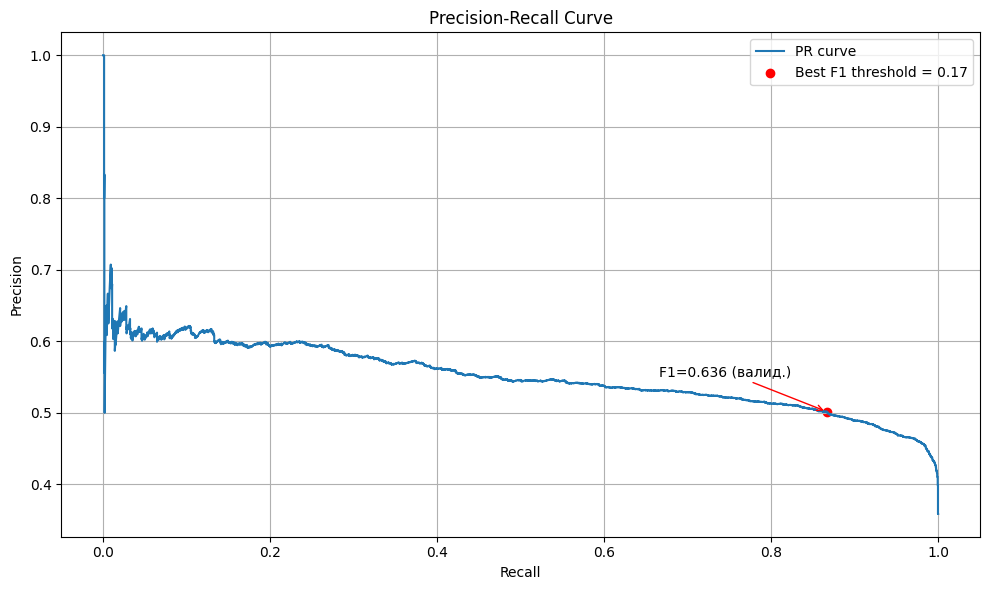

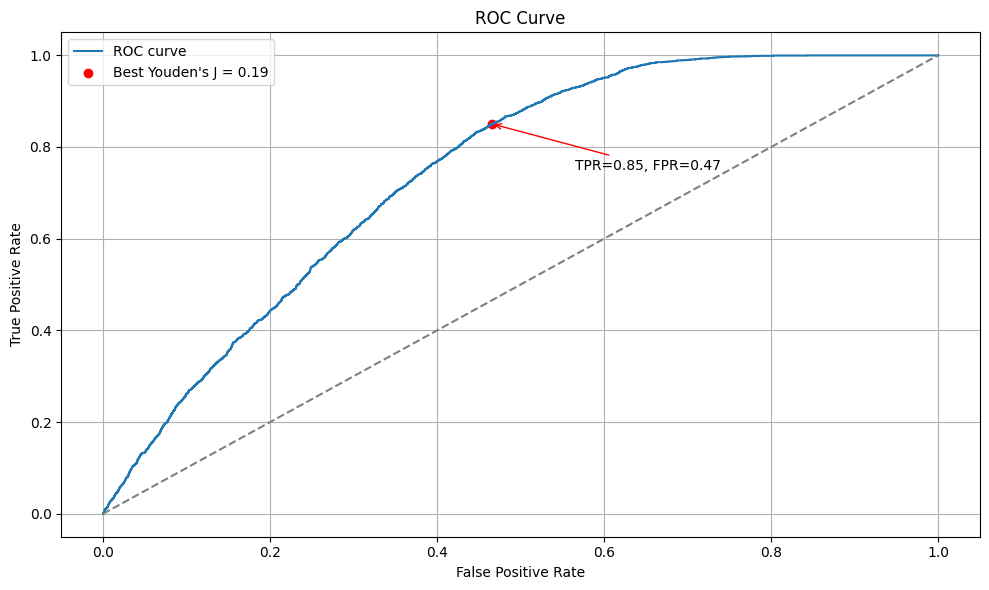

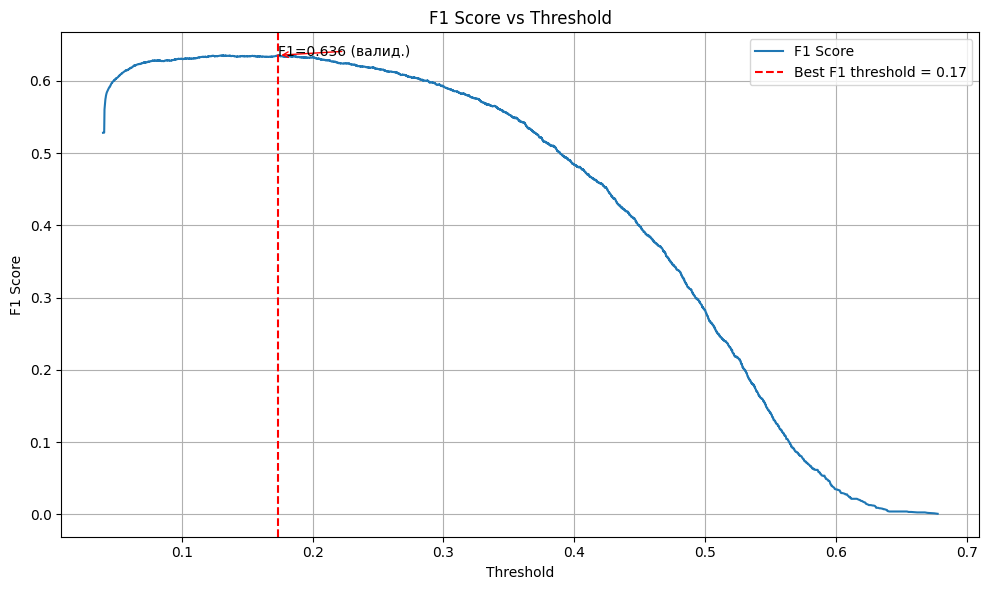

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# Precision-Recall кривая
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label="PR curve")
plt.scatter(recalls[best_f1_idx], precisions[best_f1_idx],
            color="red", label=f"Best F1 threshold = {best_f1_threshold:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.annotate(f"F1={f1_scores[best_f1_idx]:.3f} (валид.)",
             xy=(recalls[best_f1_idx], precisions[best_f1_idx]),
             xytext=(recalls[best_f1_idx] - 0.2, precisions[best_f1_idx] + 0.05),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ROC-кривая
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC curve")
plt.scatter(fpr[best_j_idx], tpr[best_j_idx],
            color="red", label=f"Best Youden's J = {best_j_threshold:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.annotate(f"TPR={tpr[best_j_idx]:.2f}, FPR={fpr[best_j_idx]:.2f}",
             xy=(fpr[best_j_idx], tpr[best_j_idx]),
             xytext=(fpr[best_j_idx]+0.1, tpr[best_j_idx]-0.1),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# График F1-метрики в зависимости от порога
plt.figure(figsize=(10, 6))
plt.plot(thresholds_pr, f1_scores[:-1], label="F1 Score")
plt.axvline(best_f1_threshold, color='red', linestyle='--', label=f"Best F1 threshold = {best_f1_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.annotate(f"F1={f1_scores[best_f1_idx]:.3f} (валид.)",
             xy=(best_f1_threshold, f1_scores[best_f1_idx]),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## XGBoost + Random Forest → LogisticRegression

In [ ]:
from sklearn.ensemble import RandomForestClassifier

df_xgb = df_1st.sort_values('date')

X = df_xgb.drop(columns=['label', 'date'])
y = df_xgb['label']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

class_counts = Counter(y_subtrain)
scale_pos_weight = class_counts[0] / class_counts[1]

xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'learning_rate': 0.25,
    'max_depth': 5,
    'subsample': 0.51,
    'colsample_bytree': 0.72,
    'reg_lambda': 0.93,
    'reg_alpha': 1.62,
    'n_estimators': 763,
    'random_state': 42,
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': 0
}

rf_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'monotonic_cst': None,
    'n_estimators': 100,
    'n_jobs': -1,
    'oob_score': False,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False,
    'class_weight': {0:1, 1:scale_pos_weight}#'balanced'
}


xgb_clf = XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss')
rf_clf = RandomForestClassifier(**rf_params)

meta_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='liblinear',
        max_iter=1000,
        class_weight={0: 1, 1: scale_pos_weight},
        random_state=42
    ))
])

cv = KFold(n_splits=5, shuffle=False)


stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('rf',  rf_clf)
        ],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=-1
)

stacking_xgb_rf = CalibratedClassifierCV(estimator=stacking_model, method='sigmoid', cv=3)
stacking_xgb_rf.fit(X_subtrain, y_subtrain)

CalibratedClassifierCV(cv=3,
                       estimator=StackingClassifier(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                    estimators=[('xgb',
                                                                 XGBClassifier(base_score=None,
                                                                               booster='gbtree',
                                                                               callbacks=None,
                                                                               colsample_bylevel=None,
                                                                               colsample_bynode=None,
                                                                               colsample_bytree=0.72,
                                                                               device=None,
                                                                               early_stopping_rounds=None,
                                                                               enable_categorical=False,
                                                                               eval_metric='logloss',
                                                                               featur...
                                                                               n_estimators=763,
                                                                               n_jobs=-1,
                                                                               num_parallel_tree=None,
                                                                               random_state=42, ...)),
                                                                ('rf',
                                                                 RandomForestClassifier(class_weight={0: 1,
                                                                                                      1: 3.6971767667685667},
                                                                                        n_jobs=-1,
                                                                                        random_state=42))],
                                                    final_estimator=Pipeline(steps=[('scaler',
                                                                                     StandardScaler()),
                                                                                    ('lr',
                                                                                     LogisticRegression(class_weight={0: 1,
                                                                                                                      1: 3.6971767667685667},
                                                                                                        max_iter=1000,
                                                                                                        random_state=42,
                                                                                                        solver='liblinear'))]),
                                                    n_jobs=-1))

In [ ]:
y_val_proba = stacking_xgb_rf.predict_proba(X_val)[:, 1]

#по F1
precisions, recalls, thresholds_pr = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_f1_idx = f1_scores[:-1].argmax()
best_f1_threshold = thresholds_pr[best_f1_idx]

#по Youden’s J
fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_proba)
youden_j = tpr - fpr
best_j_idx = youden_j.argmax()
best_j_threshold = thresholds_roc[best_j_idx]

y_test_proba = stacking_xgb_rf.predict_proba(X_test)[:, 1]
y_pred_f1 = (y_test_proba >= best_f1_threshold).astype(int)
y_pred_j = (y_test_proba >= best_j_threshold).astype(int)

print(f"\n🔹 Best F1 threshold: {best_f1_threshold:.3f}")
print(f"F1-score on test: {f1_score(y_test, y_pred_f1):.4f}")
print("Classification report (F1 threshold):")
print(classification_report(y_test, y_pred_f1, digits=3))

print(f"\n🔹 Best Youden's J threshold: {best_j_threshold:.3f}")
print(f"F1-score on test: {f1_score(y_test, y_pred_j):.4f}")
print("Classification report (Youden threshold):")
print(classification_report(y_test, y_pred_j, digits=3))


🔹 Best F1 threshold: 0.159
F1-score on test: 0.6281
Classification report (F1 threshold):
              precision    recall  f1-score   support

           0      0.881     0.443     0.589      5507
           1      0.483     0.897     0.628      3201

    accuracy                          0.610      8708
   macro avg      0.682     0.670     0.609      8708
weighted avg      0.735     0.610     0.603      8708


🔹 Best Youden's J threshold: 0.162
F1-score on test: 0.6281
Classification report (Youden threshold):
              precision    recall  f1-score   support

           0      0.878     0.448     0.593      5507
           1      0.484     0.893     0.628      3201

    accuracy                          0.611      8708
   macro avg      0.681     0.670     0.611      8708
weighted avg      0.733     0.611     0.606      8708



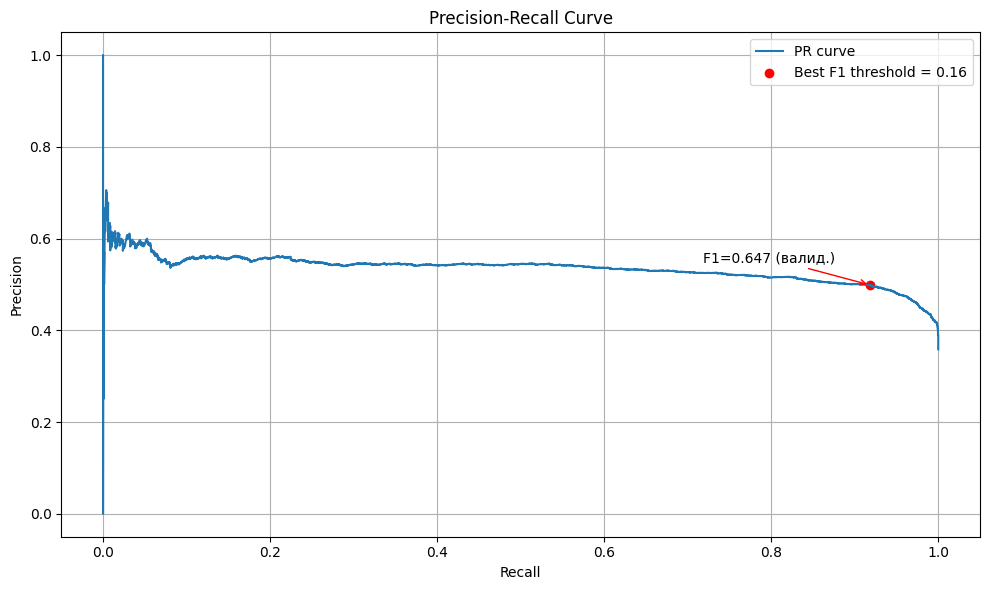

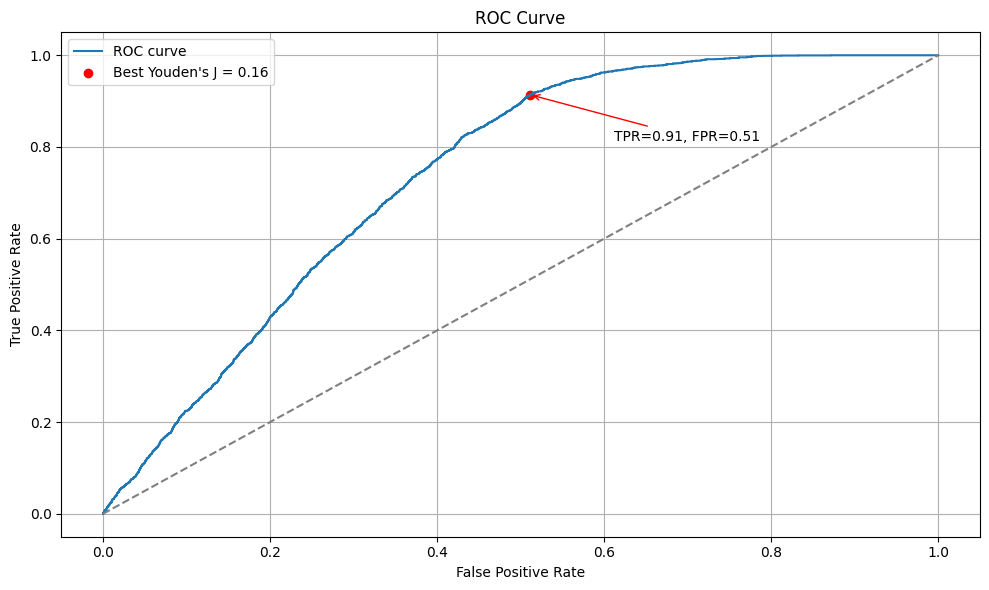

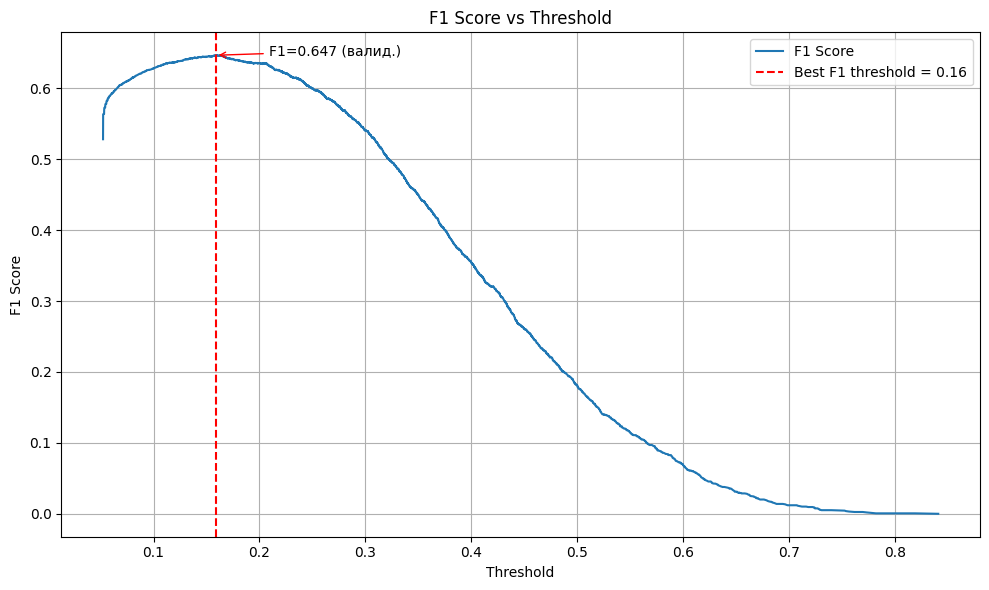

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# Precision-Recall кривая
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label="PR curve")
plt.scatter(recalls[best_f1_idx], precisions[best_f1_idx],
            color="red", label=f"Best F1 threshold = {best_f1_threshold:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.annotate(f"F1={f1_scores[best_f1_idx]:.3f} (валид.)",
             xy=(recalls[best_f1_idx], precisions[best_f1_idx]),
             xytext=(recalls[best_f1_idx] - 0.2, precisions[best_f1_idx] + 0.05),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ROC-кривая
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC curve")
plt.scatter(fpr[best_j_idx], tpr[best_j_idx],
            color="red", label=f"Best Youden's J = {best_j_threshold:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.annotate(f"TPR={tpr[best_j_idx]:.2f}, FPR={fpr[best_j_idx]:.2f}",
             xy=(fpr[best_j_idx], tpr[best_j_idx]),
             xytext=(fpr[best_j_idx]+0.1, tpr[best_j_idx]-0.1),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# График F1-метрики в зависимости от порога
plt.figure(figsize=(10, 6))
plt.plot(thresholds_pr, f1_scores[:-1], label="F1 Score")
plt.axvline(best_f1_threshold, color='red', linestyle='--', label=f"Best F1 threshold = {best_f1_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.annotate(f"F1={f1_scores[best_f1_idx]:.3f} (валид.)",
             xy=(best_f1_threshold, f1_scores[best_f1_idx]),
             xytext=(best_f1_threshold + 0.05, f1_scores[best_f1_idx]),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## CatBoost + Random Forest → LogisticRegression

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, roc_curve
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

df_xgb = df_1st.sort_values('date').reset_index(drop=True)
X = df_xgb.drop(columns=['label', 'date'])
y = df_xgb['label']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

class_counts = Counter(y_subtrain)
scale_pos_weight = class_counts[0] / class_counts[1]

cb_params = {
    'nan_mode': 'Min',
    'eval_metric': 'Logloss',
    'iterations': 1000,
    'sampling_frequency': 'PerTree',
    'leaf_estimation_method': 'Newton',
    'random_score_type': 'NormalWithModelSizeDecrease',
    'grow_policy': 'SymmetricTree',
    'penalties_coefficient': 1,
    'boosting_type': 'Plain',
    'model_shrink_mode': 'Constant',
    'feature_border_type': 'GreedyLogSum',
    'eval_fraction': 0,
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'rsm': 1,
    'boost_from_average': False,
    'model_size_reg': 0.5,
    'subsample': 0.800000011920929,
    'use_best_model': False,
    'class_names': [0, 1],
    'random_seed': 42,
    'depth': 6,
    'posterior_sampling': False,
    'border_count': 254,
    'classes_count': 0,
    'auto_class_weights': 'None',
    'sparse_features_conflict_fraction': 0,
    'leaf_estimation_backtracking': 'AnyImprovement',
    'best_model_min_trees': 1,
    'model_shrink_rate': 0,
    'min_data_in_leaf': 1,
    'loss_function': 'Logloss',
    'learning_rate': 0.044870998710393906,
    'score_function': 'Cosine',
    'task_type': 'CPU',
    'leaf_estimation_iterations': 10,
    'bootstrap_type': 'MVS',
    'max_leaves': 64,
    'auto_class_weights': 'Balanced'
}

rf_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'monotonic_cst': None,
    'n_estimators': 100,
    'n_jobs': -1,
    'oob_score': False,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False,
    'class_weight': {0:1, 1:scale_pos_weight}#'balanced'
}


rf_clf = RandomForestClassifier(**rf_params)
cb_clf = CatBoostClassifier(**cb_params)

meta_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='liblinear',
        max_iter=1000,
        class_weight={0: 1, 1: scale_pos_weight},
        random_state=42
    ))
])

cv = KFold(n_splits=5, shuffle=False)


stacking_model = StackingClassifier(
    estimators=[('cb', cb_clf), ('rf', rf_clf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=-1
)

stacking_cb_rf = CalibratedClassifierCV(estimator=stacking_model, method='sigmoid', cv=3)
stacking_cb_rf.fit(X_subtrain, y_subtrain)

CalibratedClassifierCV(cv=3,
                       estimator=StackingClassifier(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                    estimators=[('cb',
                                                                 <catboost.core.CatBoostClassifier object at 0x79eb85f11210>),
                                                                ('rf',
                                                                 RandomForestClassifier(class_weight={0: 1,
                                                                                                      1: 3.6971767667685667},
                                                                                        n_jobs=-1,
                                                                                        random_state=42))],
                                                    final_estimator=Pipeline(steps=[('scaler',
                                                                                     StandardScaler()),
                                                                                    ('lr',
                                                                                     LogisticRegression(class_weight={0: 1,
                                                                                                                      1: 3.6971767667685667},
                                                                                                        max_iter=1000,
                                                                                                        random_state=42,
                                                                                                        solver='liblinear'))]),
                                                    n_jobs=-1))

In [ ]:
import joblib

joblib.dump(stacking_cb_rf, 'stacking_cb_rf_model.pkl')

['stacking_cb_rf_model.pkl']

In [ ]:
y_val_proba = stacking_cb_rf.predict_proba(X_val)[:, 1]

#по F1
precisions, recalls, thresholds_pr = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_f1_idx = f1_scores[:-1].argmax()
best_f1_threshold = thresholds_pr[best_f1_idx]

#по Youden’s J
fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_proba)
youden_j = tpr - fpr
best_j_idx = youden_j.argmax()
best_j_threshold = thresholds_roc[best_j_idx]

# По максимальному Precision
# Чтобы не брать последний порог, где precision=1 при recall=0, возьмем максимальное precision с recall > 0
# По максимальному Precision (с условием recall > 0)
valid_idx = recalls[:-1] > 0
precisions_valid = precisions[:-1][valid_idx]
thresholds_valid = thresholds_pr[valid_idx]

best_prec_idx = precisions_valid.argmax()
best_prec_threshold = thresholds_valid[best_prec_idx]

y_test_proba = stacking_cb_rf.predict_proba(X_test)[:, 1]
y_pred_f1 = (y_test_proba >= best_f1_threshold).astype(int)
y_pred_j = (y_test_proba >= best_j_threshold).astype(int)
y_pred_prec = (y_test_proba >= best_prec_threshold).astype(int)

print(f"\n🔹 Best F1 threshold: {best_f1_threshold:.3f}")
print(f"F1-score on test: {f1_score(y_test, y_pred_f1):.4f}")
print("Classification report (F1 threshold):")
print(classification_report(y_test, y_pred_f1, digits=3))

print(f"\n🔹 Best Youden's J threshold: {best_j_threshold:.3f}")
print(f"F1-score on test: {f1_score(y_test, y_pred_j):.4f}")
print("Classification report (Youden threshold):")
print(classification_report(y_test, y_pred_j, digits=3))

print(f"\n🔹 Best Precision threshold: {best_prec_threshold:.3f}")
precision_test = precision_score(y_test, y_pred_prec)
print(f"Precision on test: {precision_test:.4f}")
print("Classification report (Precision threshold):")
print(classification_report(y_test, y_pred_prec, digits=3))


🔹 Best F1 threshold: 0.126
F1-score on test: 0.6303
Classification report (F1 threshold):
              precision    recall  f1-score   support

           0      0.913     0.402     0.558      5507
           1      0.476     0.934     0.630      3201

    accuracy                          0.597      8708
   macro avg      0.694     0.668     0.594      8708
weighted avg      0.752     0.597     0.585      8708


🔹 Best Youden's J threshold: 0.172
F1-score on test: 0.6307
Classification report (Youden threshold):
              precision    recall  f1-score   support

           0      0.873     0.468     0.609      5507
           1      0.491     0.883     0.631      3201

    accuracy                          0.620      8708
   macro avg      0.682     0.675     0.620      8708
weighted avg      0.732     0.620     0.617      8708


🔹 Best Precision threshold: 0.714
Precision on test: 0.5676
Classification report (Precision threshold):
              precision    recall  f1-score   

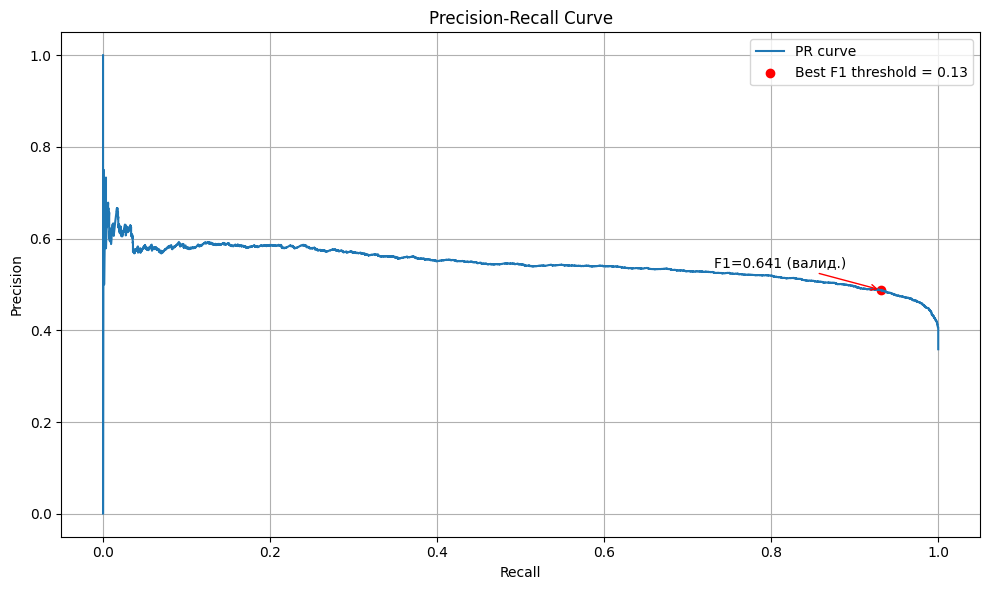

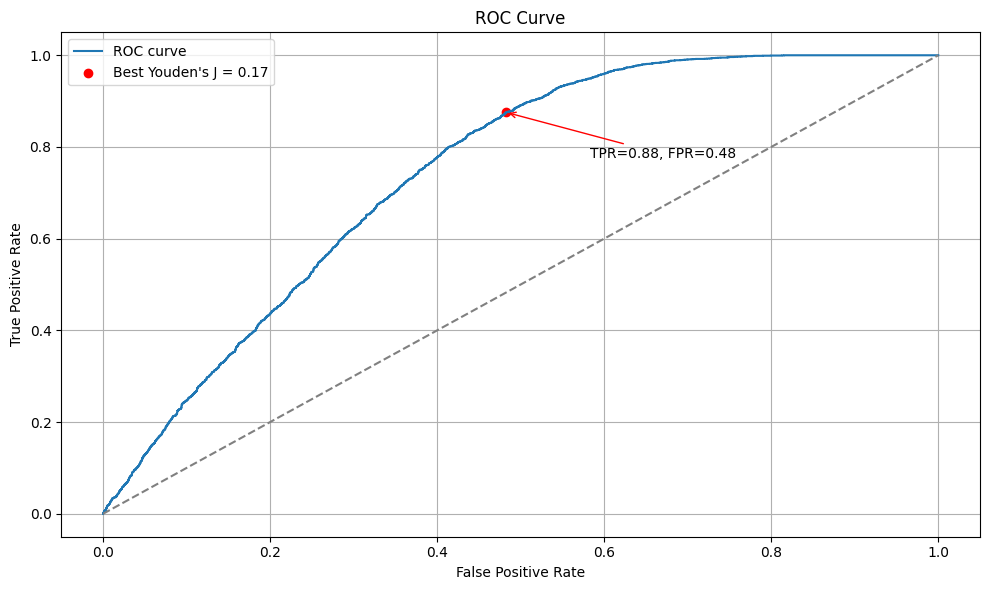

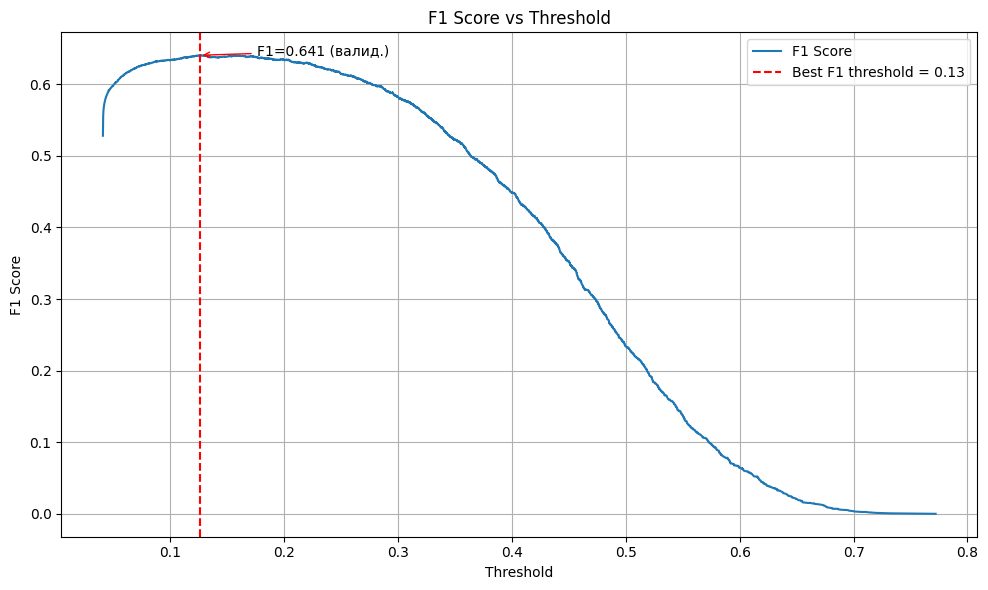

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# Precision-Recall кривая
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label="PR curve")
plt.scatter(recalls[best_f1_idx], precisions[best_f1_idx],
            color="red", label=f"Best F1 threshold = {best_f1_threshold:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.annotate(f"F1={f1_scores[best_f1_idx]:.3f} (валид.)",
             xy=(recalls[best_f1_idx], precisions[best_f1_idx]),
             xytext=(recalls[best_f1_idx] - 0.2, precisions[best_f1_idx] + 0.05),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ROC-кривая
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC curve")
plt.scatter(fpr[best_j_idx], tpr[best_j_idx],
            color="red", label=f"Best Youden's J = {best_j_threshold:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.annotate(f"TPR={tpr[best_j_idx]:.2f}, FPR={fpr[best_j_idx]:.2f}",
             xy=(fpr[best_j_idx], tpr[best_j_idx]),
             xytext=(fpr[best_j_idx]+0.1, tpr[best_j_idx]-0.1),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# График F1-метрики в зависимости от порога
plt.figure(figsize=(10, 6))
plt.plot(thresholds_pr, f1_scores[:-1], label="F1 Score")
plt.axvline(best_f1_threshold, color='red', linestyle='--', label=f"Best F1 threshold = {best_f1_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.annotate(f"F1={f1_scores[best_f1_idx]:.3f} (валид.)",
             xy=(best_f1_threshold, f1_scores[best_f1_idx]),
             xytext=(best_f1_threshold + 0.05, f1_scores[best_f1_idx]),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## XGBoost + CatBoost + Random Forest → LogisticRegression

In [ ]:
df_xgb = df_1st.sort_values('date').reset_index(drop=True)
X = df_xgb.drop(columns=['label', 'date'])
y = df_xgb['label']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

class_counts = Counter(y_subtrain)
scale_pos_weight = class_counts[0] / class_counts[1]

xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'learning_rate': 0.25,
    'max_depth': 5,
    'subsample': 0.51,
    'colsample_bytree': 0.72,
    'reg_lambda': 0.93,
    'reg_alpha': 1.62,
    'n_estimators': 763,
    'random_state': 42,
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': 0
}

cb_params = {
    'nan_mode': 'Min',
    'eval_metric': 'Logloss',
    'iterations': 1000,
    'sampling_frequency': 'PerTree',
    'leaf_estimation_method': 'Newton',
    'random_score_type': 'NormalWithModelSizeDecrease',
    'grow_policy': 'SymmetricTree',
    'penalties_coefficient': 1,
    'boosting_type': 'Plain',
    'model_shrink_mode': 'Constant',
    'feature_border_type': 'GreedyLogSum',
    'eval_fraction': 0,
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'rsm': 1,
    'boost_from_average': False,
    'model_size_reg': 0.5,
    'subsample': 0.800000011920929,
    'use_best_model': False,
    'class_names': [0, 1],
    'random_seed': 42,
    'depth': 6,
    'posterior_sampling': False,
    'border_count': 254,
    'classes_count': 0,
    'auto_class_weights': 'None',
    'sparse_features_conflict_fraction': 0,
    'leaf_estimation_backtracking': 'AnyImprovement',
    'best_model_min_trees': 1,
    'model_shrink_rate': 0,
    'min_data_in_leaf': 1,
    'loss_function': 'Logloss',
    'learning_rate': 0.044870998710393906,
    'score_function': 'Cosine',
    'task_type': 'CPU',
    'leaf_estimation_iterations': 10,
    'bootstrap_type': 'MVS',
    'max_leaves': 64,
    'auto_class_weights': 'Balanced'
}

rf_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'monotonic_cst': None,
    'n_estimators': 100,
    'n_jobs': -1,
    'oob_score': False,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False,
    'class_weight': {0:1, 1:scale_pos_weight}#'balanced'
}

xgb_clf = XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss')
rf_clf = RandomForestClassifier(**rf_params)
cb_clf = CatBoostClassifier(**cb_params)

meta_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='liblinear',
        max_iter=1000,
        class_weight={0: 1, 1: scale_pos_weight},
        random_state=42
    ))
])

cv = KFold(n_splits=5, shuffle=False)


stacking_model = StackingClassifier(
    estimators=[('xgb', xgb_clf), ('cb', cb_clf), ('rf', rf_clf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=-1
)

stacking_xgb_cb_rf = CalibratedClassifierCV(estimator=stacking_model, method='sigmoid', cv=3)
stacking_xgb_cb_rf.fit(X_subtrain, y_subtrain)

CalibratedClassifierCV(cv=3,
                       estimator=StackingClassifier(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                    estimators=[('xgb',
                                                                 XGBClassifier(base_score=None,
                                                                               booster='gbtree',
                                                                               callbacks=None,
                                                                               colsample_bylevel=None,
                                                                               colsample_bynode=None,
                                                                               colsample_bytree=0.72,
                                                                               device=None,
                                                                               early_stopping_rounds=None,
                                                                               enable_categorical=False,
                                                                               eval_metric='logloss',
                                                                               featur...
                                                                ('cb',
                                                                 <catboost.core.CatBoostClassifier object at 0x7eb9e812d510>),
                                                                ('rf',
                                                                 RandomForestClassifier(class_weight={0: 1,
                                                                                                      1: 3.6971767667685667},
                                                                                        n_jobs=-1,
                                                                                        random_state=42))],
                                                    final_estimator=Pipeline(steps=[('scaler',
                                                                                     StandardScaler()),
                                                                                    ('lr',
                                                                                     LogisticRegression(class_weight={0: 1,
                                                                                                                      1: 3.6971767667685667},
                                                                                                        max_iter=1000,
                                                                                                        random_state=42,
                                                                                                        solver='liblinear'))]),
                                                    n_jobs=-1))

In [ ]:
y_val_proba = stacking_xgb_cb_rf.predict_proba(X_val)[:, 1]

#по F1
precisions, recalls, thresholds_pr = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_f1_idx = f1_scores[:-1].argmax()
best_f1_threshold = thresholds_pr[best_f1_idx]

#по Youden’s J
fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_proba)
youden_j = tpr - fpr
best_j_idx = youden_j.argmax()
best_j_threshold = thresholds_roc[best_j_idx]

y_test_proba = stacking_xgb_cb_rf.predict_proba(X_test)[:, 1]
y_pred_f1 = (y_test_proba >= best_f1_threshold).astype(int)
y_pred_j = (y_test_proba >= best_j_threshold).astype(int)

print(f"\n🔹 Best F1 threshold: {best_f1_threshold:.3f}")
print(f"F1-score on test: {f1_score(y_test, y_pred_f1):.4f}")
print("Classification report (F1 threshold):")
print(classification_report(y_test, y_pred_f1, digits=3))

print(f"\n🔹 Best Youden's J threshold: {best_j_threshold:.3f}")
print(f"F1-score on test: {f1_score(y_test, y_pred_j):.4f}")
print("Classification report (Youden threshold):")
print(classification_report(y_test, y_pred_j, digits=3))


🔹 Best F1 threshold: 0.135
F1-score on test: 0.6313
Classification report (F1 threshold):
              precision    recall  f1-score   support

           0      0.906     0.414     0.568      5507
           1      0.479     0.926     0.631      3201

    accuracy                          0.602      8708
   macro avg      0.693     0.670     0.600      8708
weighted avg      0.749     0.602     0.592      8708


🔹 Best Youden's J threshold: 0.166
F1-score on test: 0.6304
Classification report (Youden threshold):
              precision    recall  f1-score   support

           0      0.879     0.455     0.599      5507
           1      0.487     0.892     0.630      3201

    accuracy                          0.615      8708
   macro avg      0.683     0.673     0.615      8708
weighted avg      0.735     0.615     0.611      8708



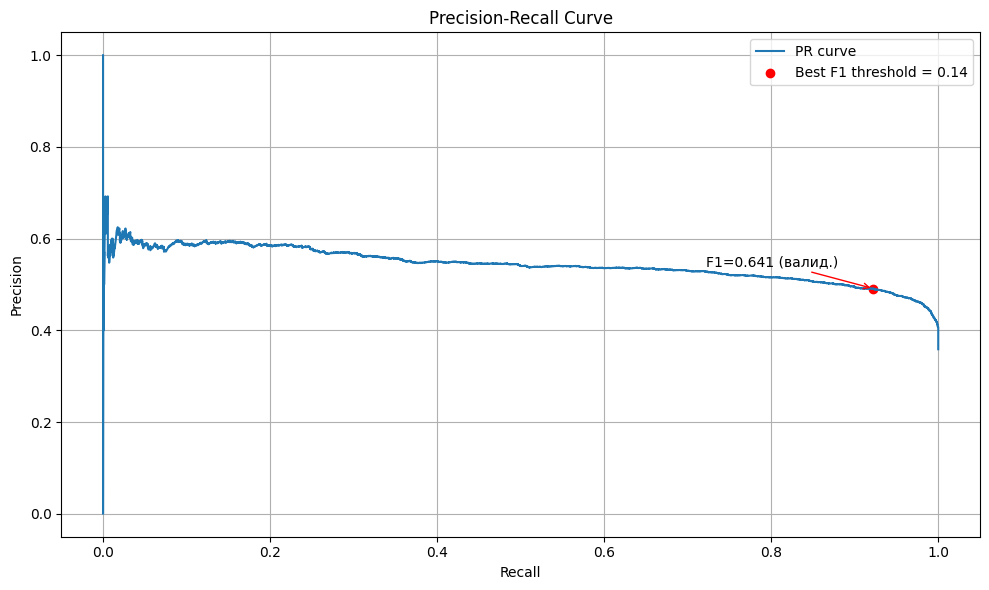

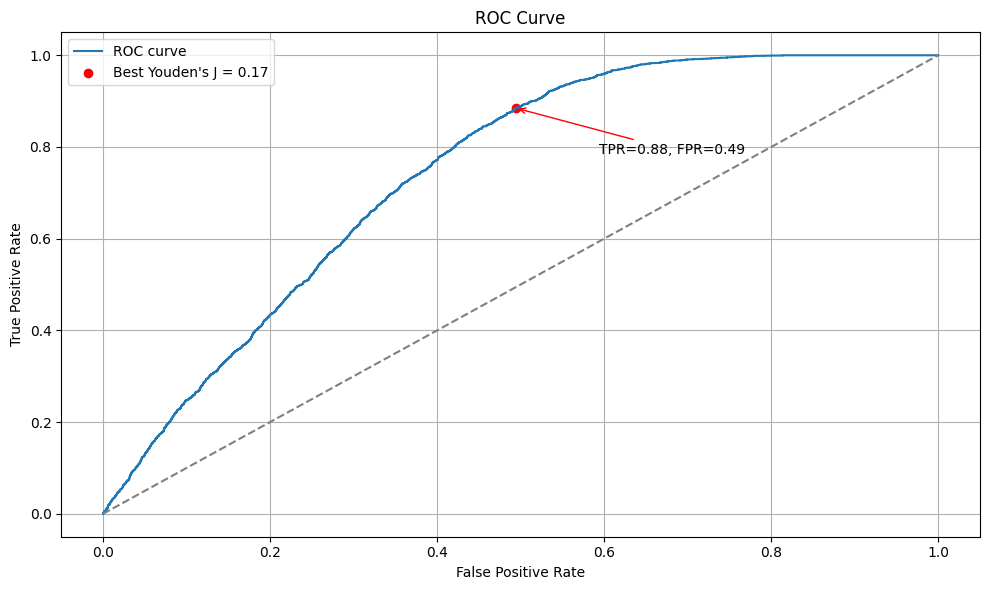

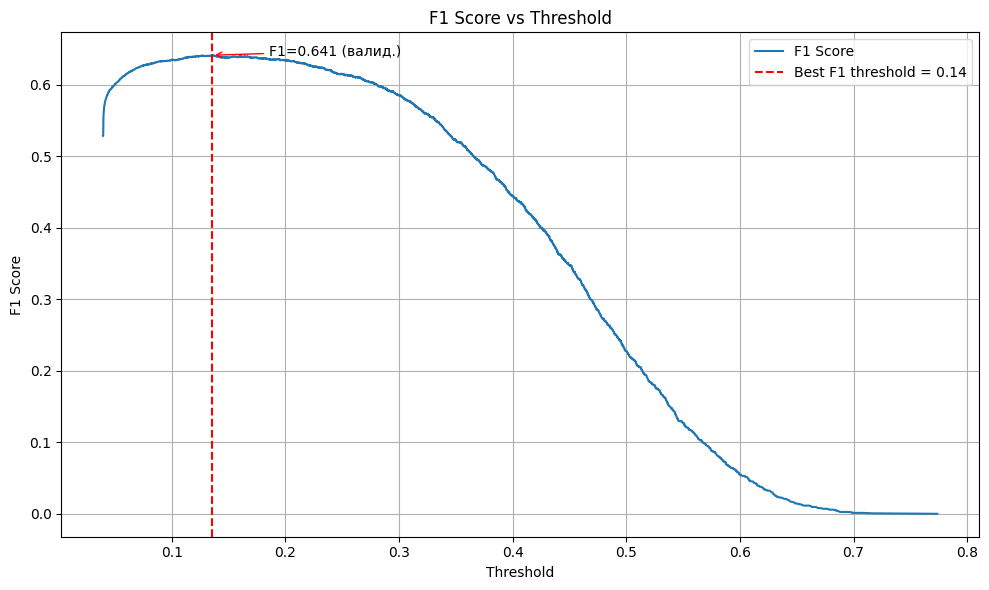

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# Precision-Recall кривая
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label="PR curve")
plt.scatter(recalls[best_f1_idx], precisions[best_f1_idx],
            color="red", label=f"Best F1 threshold = {best_f1_threshold:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.annotate(f"F1={f1_scores[best_f1_idx]:.3f} (валид.)",
             xy=(recalls[best_f1_idx], precisions[best_f1_idx]),
             xytext=(recalls[best_f1_idx] - 0.2, precisions[best_f1_idx] + 0.05),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ROC-кривая
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC curve")
plt.scatter(fpr[best_j_idx], tpr[best_j_idx],
            color="red", label=f"Best Youden's J = {best_j_threshold:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.annotate(f"TPR={tpr[best_j_idx]:.2f}, FPR={fpr[best_j_idx]:.2f}",
             xy=(fpr[best_j_idx], tpr[best_j_idx]),
             xytext=(fpr[best_j_idx]+0.1, tpr[best_j_idx]-0.1),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# График F1-метрики в зависимости от порога
plt.figure(figsize=(10, 6))
plt.plot(thresholds_pr, f1_scores[:-1], label="F1 Score")
plt.axvline(best_f1_threshold, color='red', linestyle='--', label=f"Best F1 threshold = {best_f1_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.annotate(f"F1={f1_scores[best_f1_idx]:.3f} (валид.)",
             xy=(best_f1_threshold, f1_scores[best_f1_idx]),
             xytext=(best_f1_threshold + 0.05, f1_scores[best_f1_idx]),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Сравнение XGBoost и моделей стекинга при оптимизации порогов по F1 и индексу Юдена

## Порог по максимальному F1

| Модель                            | Порог-F1 |  Acc  | Prec (0)  |  Rec (0) |  F1 (0)  | Prec (1) |  Rec (1) |  F1 (1)  | Macro-F1 | Weighted-F1 |
| :-------------------------------- | :----: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :------: | :----: |
| **Single XGBoost**                |   0.268   |   0.590   |   0.910   |   0.390   |   0.550   |   0.470   |   0.930   |   0.630   |   0.590   |   0.580   |
| **CatBoost + XGBoost → LR**       |   0.174   |   0.617   |   0.874   |   0.461   |   0.604   |   0.489   |   0.885   |   0.630   |   0.617   |   0.613   |
| **XGBoost + Random Forest → LR**  |   0.159   |   0.610   |   0.881   |   0.443   |   0.589   |   0.483   |   0.897   |   0.628   |   0.609   |   0.603   |
| **CatBoost + Random Forest → LR** |   0.126   |   0.597   |   0.913   |   0.402   |   0.558   |   0.476   |   0.934   |   0.630   |   0.594   |   0.585   |
| **XGBoost + CatBoost + RF → LR**  | 0.135 | 0.602 | 0.906 | 0.414 | 0.568 | 0.479 | 0.926 | 0.631 | 0.600 | 0.592 |



## Порог по максимуму Youden’s J

| Модель                            | Порог-J |  Acc  | Prec (0) |  Rec (0) |  F1 (0)  | Prec (1) |  Rec (1) |  F1 (1)  | Macro-F1 | Weighted-F1 |
| :-------------------------------- | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :------: | :----: |
| **Single XGBoost**                |   0.439   |   0.620   |   0.840   |   0.490   |   0.620   |   0.490   |   0.840   |   0.620   |   0.620   |   0.620   |
| **CatBoost + XGBoost → LR**       |   0.186   |   0.620   |   0.862   |   0.474   |   0.612   |   0.490   |   0.869   |   0.627   |   0.619   |   0.617   |
| **XGBoost + Random Forest → LR**  |   0.162   |   0.611   |   0.878   |   0.448   |   0.593   |   0.484   |   0.893   |   0.628   |   0.611   |   0.606   |
| **CatBoost + Random Forest → LR** |   0.172   |   0.620   |   0.873   |   0.468   |   0.609   |   0.491   |   0.883   |   0.631   |   0.620   |   0.617   |
| **XGBoost + CatBoost + RF → LR**  | 0.166 | 0.615 | 0.879 | 0.455 | 0.599 | 0.487 | 0.892 | 0.630 | 0.615 | 0.611 |



, где Macro-F1 среднее F1-score по всем классам, а Weighted-F1 -  средневзвешенное значение F1-score по всем классам, где весом каждого класса является количество его истинных примеров (support)

# Общие выводы по результатам экспериментов, выбор моделей для различных сценариев

## Одиночная модель (XGBoost):
- Максимальный F1-score ≈ 0.63
- Лучшие метрики достигаются при пороге по Youden’s J: модель сбалансированно предсказывает оба класса (F1 = 0.62 для каждого класса, точность и полнота на уровне ~0.84 и ~0.49).

## Стекинг CatBoost + XGBoost → Logistic Regression
- Максимальный F1-score ≈ 0.63
- Лучшее качество достигается при подборе порога по F1:
  - Recall класса 1 (пожары) достигает 88.5 % — это один из лучших результатов.
  - Precision по классу 0 (непожары) также высокий — около 87.4 %.
- Модель демонстрирует хороший баланс между точностью и полнотой, особенно при высокой полноте по пожарам.

## Стекинг XGBoost + Random Forest → Logistic Regression
- F1-score стабильно ≈ 0.628
- При любом способе подбора порога модель выдаёт почти идентичные результаты.
- Cтекинг с умеренным балансом между precision и recall.
- Выигрывает у одиночной модели, но немного уступает другим стекингам по полноте.

## Стекинг CatBoost + Random Forest → Logistic Regression
- F1-score достигает ≈ 0.631
- Особенно хорош при пороге по Youden’s J:
  - Recall по классу 1 = 88.3 % при разумной точности.
  - F1 по классу 1 = 0.63 — наивысшее значение среди всех моделей.
- Отличается обнаружением положительного класса при приемлемом уровне ложных срабатываний.

## Полный стекинг (XGBoost + CatBoost + Random Forest → Logistic Regression)
- Наивысший F1-score ≈ 0.631
- Метрики практически идентичны стекингу CatBoost+Random Forest.
- Улучшения по сравнению с двойным стекингом минимальны.





----

## Наиболее сбалансированные и устойчивые модели — это стекинги из CatBoost + Random Forest и CatBoost + XGBoost (мета-модель Logistic Regression)
Они демонстрируют:
- Высокий F1-score по классу 1 (до ~0.63),
- Хорошее соотношение между precision и recall по обоим классам,
- Максимальные значения macro и weighted F1-score среди всех протестированных моделей.

## Полный стекинг (XGBoost + CatBoost + Random Forest) не даёт ощутимого прироста по метрикам:
- Значения F1-score, Recall и других метрик практически совпадают с двухмодельными стекингами.
- При этом время обучения возрастает

## Подбор порога (по максимальному F1 или по критерию Youden's J) существенно влияет на поведение модели:
- Порог по F1 смещает акцент на повышение F1-score класса 1, что может быть полезно, если главная задача — не упустить ни одного пожара.
- Порог по Youden's J стремится к балансу между точностью и полнотой для обоих классов — может быть более подходящим, если одинаково важны как пожары, так и "непожары".
- Выбор порога зависит от приоритетов и требований конкретных заказчиков или пользователей.

---

# Выбор моделей для различных сценариев

## Если цель обнаружить максимум пожаров, даже если это увеличивает ложные срабатывания (потенциальный заказчик - МЧС России):

## CatBoost + XGBoost → Logistic Regression:
- Компромисс между полнотой и устойчивостью модели.
- Более сбалансирована по сравнению с CatBoost + Random Forest, где Precision выше, но Recall чуть ниже.

## Если цель минимизировать затраты на ложные выезды, но не упустить реальные пожары (потенциальный заказчик - Рослесхоз):

## CatBoost + Random Forest → Logistic Regression:
- лучший баланс между precision и recall, а это как раз то, что нужно - точные, но не избыточные сигналы.

## Если цель предотвращение катастроф и ущерба в высокорисковых зонах, упор на непропущенные пожары (потенциальный заказчик - Нефтегазовые компании):

## CatBoost + XGBoost → Logistic Regression:
- Обнаружение пожаров при адекватной точности.

Результаты выбора представлены в таблице ниже

| Заказчик                  | Выбранная модель   | Аргументы                                                                | Порог     | Критерий выбора порога |
| ------------------------- | ------------------------ | -------------------------------------------------------------------------------- | --------- | ---------------------- |
| **МЧС России**            | CatBoost + XGBoost       | Высокий **Recall (0.885)** и **F1 (0.630)** при хорошей устойчивости, простота по сравнению с полным стекингом             | **0.174** | **F1-score**           |
| **Рослесхоз**             | CatBoost + Random Forest | Лучшее сочетание **Precision (0.491)** и F1, умеренный Recall (0.883), минимизация ложных тревог            | **0.172** | **Youden's J**         |
| **Нефтегазовые компании** | CatBoost + XGBoost       | Отличный **Recall (0.885)** с адекватной точностью, надёжное обнаружение пожаров | **0.174** | **F1-score**           |


---

## Обьединение CNN и CatBoost + Random Forest

Поскольку табличный стекинг (CatBoost + RF→LR) и CNN по снимкам обучены на разнородных данных без жёсткого соответствия «каждое измерение погоды - конкретное изображение», то их выходные вероятности нельзя собирать построчно для обучения общей модели. Вместо этого будут использоватьсся формулы объединения.

  В задаче обнаружения лесных пожаров мы используем два независимых источника информации:  
1. **Табличная модель** (CatBoost + RF → Logistic Regression), обученная на метеоданных и показавшая сбалансированный precision/recall.  
2. **CNN**, распознающая пожар по спутниковым изображениям и выдающая вероятность события.  

Обе модели важны, но они «смотрят» на задачу по-разному, и у нас нет прямого соответствия «каждой записи погоды ←→ конкретному снимку». Поэтому классический стекинг не применим, поэтому объединим их выходы через формулу.

---

## Обоснование выбора подхода  
- **Независимые данные**: табличные признаки и спутниковые снимки не совпадают по экземплярам.  
- **Независимые оценки**: каждая модель выдаёт скалярную вероятность пожара.  
- **Литературная поддержка**: в работах по ансамблевому обучению (sum rule) взвешенное усреднение вероятностей часто даёт стабильный результат без дополнительного обучения мета-модели.

---

## Подход: взвешенное усреднение  

1. **Вычисление финальной вероятности**  
   p_final = α * p_tab + (1 – α) * p_cnn  
   где  
   - p_tab — вероятность пожара по табличной модели  
   - p_cnn — вероятность пожара по CNN  
   - α — вес табличной модели (0.5 при равном доверии)

2. **Пороговое решение**  
   если p_final > τ, то y_pred = 1 (пожар),  
   иначе y_pred = 0 (нет пожара)  
   где τ — порог (обычно 0.5)

---

## Поведение при разных сигналах  
- **Обе модели «за»**  
  p_tab ≈ 0.9, p_cnn ≈ 0.8  
  p_final = 0.5 * 0.9 + 0.5 * 0.8 = 0.85 → y_pred = 1  
- **Обе модели «против»**  
  p_tab ≈ 0.1, p_cnn ≈ 0.2  
  p_final = 0.5 * 0.1 + 0.5 * 0.2 = 0.15 → y_pred = 0  
- **Конфликт моделей**  
  p_tab = 0.9, p_cnn = 0.1  
  p_final = 0.5 * 0.9 + 0.5 * 0.1 = 0.5 → y_pred зависит от τ (зона сомнения)

---

## Преимущества  
- **Простота и интерпретируемость:** легко объяснить, как оценка каждой модели влияет на итог.
- **Сохранение баланса:** усреднение не сдвигает систему к крайностям, поддерживает исходный баланс precision/recall табличной модели.
- **Гибкость:** регулируя α и τ, можно подстроиться под любые требования к ошибкам.

#Разбор сценария: обнаружение антропогенного пожара через усреднение прогнозов табличной модели и CNN

В рамках проекта планиурется реализация функции автоматического оповещения с формирмированием сообщение о возможном антропогенном характере пожара. Ниже представлено описание работы при таких ситуациях.

Представим участок леса, над которым метеорологическая модель (CatBoost + RF→LR) даёт низкую вероятность возгорания — например, из-за повышенной влажности и слабого ветра она оценивает риск всего в 12 % (p_tab=0.12). CNN при этом даёт событию 91 % вероятность пожара (p_cnn=0.91). Такая картина часто возникает при поджоге или розжиге костра человеком: природные условия не способствуют возгоранию, но визуальные признаки уже налицо.

Обьединение двух прогнозов простым усреднением с равным весом (α=0.5):
p_final = 0.5 × 0.12 + 0.5 × 0.91 = 0.515.

Пороговое правило p_final > 0.5 переводит этот случай в категорию «пожар». Чтобы различить природные и антропогенные очаги, будем смотреть ещё и исходное значение p_tab: в нашем примере p_tab < 0.5, то есть погодная модель не видит пожар. Это может указывать на то, что пожар возник не из-за засухи или ветра, а благодаря человеческой активности.

В итоге все вероятности можно разделить на три групы:
1. **Нет пожара**:  
   - Условие: p_final ≤ 0.5  
   - Оба источника не дают уверенный сигнал.  

2. **Возможный антропогенный пожар**:  
   - Условие: p_final > 0.5  **и**  p_tab < 0.5  
   - CNN «видит» пожар, тогда как погодные условия не способствуют возгоранию.  
   - Интерпретация: вероятный очаг, инициированный человеком (костёр, поджог), а не природными факторами.

3. **Вероятный естественный пожар**:  
   - Условие: p_final > 0.5  **и**  p_tab ≥ 0.5  
   - Погодные условия и/или визуальные признаки согласованно указывают на пожар.  
   - Интерпретация: традиционное природное возгорание (засуха + жара + ветер).

### Преимущества

- **Ясная трактовка**  
  Три зоны чётко разделяют отсутствие пожара, подозрение на антропогенный фактор и классический природный пожар.

- **Баланс precision/recall**  
  Порог p_final = 0.5 оптимален для удержания баланса табличной модели, при этом зона антропогенного пожара отсекает только случаи, где p_tab слаб (<0.5) — то есть минимизирует ложные тревоги природного пожара.

- **Гибкость реагирования**  
  В рамках одной схемы можно по-разному обрабатывать тревоги:  
  - «природные» автоматом передавать в оперативку,  
  - «антропогенные» — проверять вручную или отправлять превентивные патрули.

- **Интеграция разных сигналов**  
  Используется и табличная, и визуальная модель без создания сложного мета-обучения, при этом учитывается, что природный и человеко-сгенерированный пожар имеют разную природу.

## Выводы
Такой метод позволяет сохранять баланс общей системы и особо выделять случаи когда есть визуальный сигнал от CNN и отсутствие сигнала от погодных данных. В результате мы автоматически помечаем ситуацию как «возможный антропогенный пожар» и можем направить к точке дополнительную оперативную группу или организовать выезд лесной охраны для подтверждения.


## Анализ ошибок модели с помощью SHAP

В этом разделе мы проведём детальный разбор самых критичных ошибок стекинга CatBoost + Random Forest → LogisticRegression при пороге Youden’s J = 0.172. Сначала выделим случаи ложных срабатываний (FP) и пропусков реальных пожаров (FN), а затем с помощью методов SHAP и LIME локально объясним, какие табличные признаки «толкнули» модель к неверному решению. Это позволит выявить закономерности ошибок и наметить конкретные шаги по улучшению качества прогноза.

In [ ]:
#Выделяем ошибки
y_val_proba = stacking_cb_rf.predict_proba(X_val)[:, 1]
thr_j = 0.172
y_val_pred_j = (y_val_proba >= thr_j).astype(int)

#Индексы FP: модель предсказала 1, а на самом деле 0
fp_idx = np.where((y_val_pred_j == 1) & (y_val == 0))[0]
#Индексы FN: модель предсказала 0, а на самом деле 1
fn_idx = np.where((y_val_pred_j == 0) & (y_val == 1))[0]

#FP с высокой уверенностью: p ≥ 0.75 и на самом деле 0 (0.75 так как с большими вероятностями нету)
fp_hc = fp_idx[y_val_proba[fp_idx] > 0.75]
#FN с высокой уверенностью: p ≤ 0.05 и на самом деле 1
fn_hc = fn_idx[y_val_proba[fn_idx] < 0.05]

print(f"False Positives: {len(fp_idx)}, False Negatives: {len(fn_idx)}")

False Positives: 2693, False Negatives: 390


  0%|          | 0/1 [00:00<?, ?it/s]

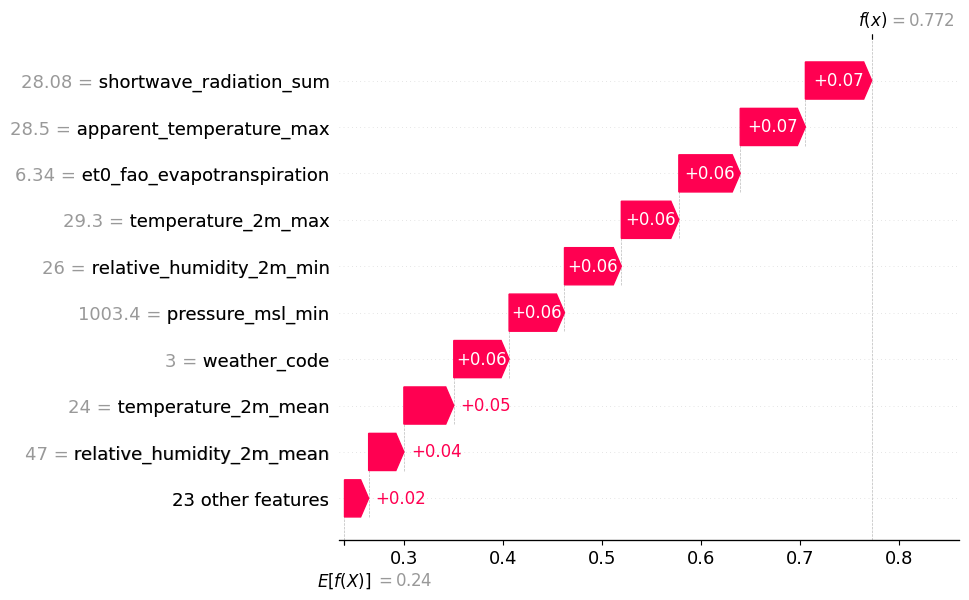

In [ ]:
import shap

#FP

def model_proba(X_array):
    X_df = pd.DataFrame(X_array, columns=X_subtrain.columns)
    return stacking_cb_rf.predict_proba(X_df)[:, 1]

background = X_subtrain.sample(100, random_state=42).values
explainer = shap.KernelExplainer(model_proba, background)

idx = fp_hc[0]
x_example = X_val.iloc[[idx]].values

shap_values = explainer.shap_values(x_example, nsamples=200)

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_val.iloc[idx],
        feature_names=X_val.columns
    )
)

## Ложноположительный прогноз с высокой уверенностью (FP high-confidence)
В данном случае модель ошибочно предсказала пожар (предсказание — 1), несмотря на то, что его не было (истинное значение — 0).

## Наиболее значимые признаки, повлиявшие на это решение:
- **shortwave_radiation_sum** `+0.07`  
  интенсивная солнечная радиация дополнительно сушит поверхность
- **apparent_temperature_max** `+0.07`  
  высокая «ощущаемая» температура усиливает риск воспламенения
- **et0_fao_evapotranspiration** `+0.06`  
  повышенная испаряемость указывает на сухость растительности и почвы
- **temperature_2m_max** `+0.06`  
  высокая дневная температура увеличивает шансы самовоспламенения
- **relative_humidity_2m_min** `+0.06`  
  минимальная влажность остаётся низкой, что способствует возгоранию
- **pressure_msl_min** `+0.06`  
  низкое атмосферное давление может сигнализировать о нестабильных погодных условиях

Модель классифицировала ситуацию как высоко пожароопасную на основании комплекса признаков: высокая испаряемость, солнечная активность, жара, ветер и сухость атмосферы. Такое сочетание характерно для реальных случаев пожаров, поэтому модель уверенно предсказала пожар.

Исходя из того, что достоверно узнать причины такого случая не представится возможным, можно попробовать разработать комплекс мер для обработки таких случаев на следующих этапах разработки продукта.

## Возможные меры для снижения подобных ложных срабатываний:
- добавить признаки, отражающие антропогенное влияние (близость к дорогам, туризм, населённые пункты)
- учесть данные об источниках возгорания (молнии, пожары в соседних квадратах, техногенные факторы)
- ввести информацию о типе поверхности и растительности (лес, болото, луг и тд)
- добавление индексов экстремальности погоды (внезапное повышение температуры, порывистый ветер).
- локальная адаптации: учитывать географические особенности и исторические аномалии в конкретном регионе.

  0%|          | 0/1 [00:00<?, ?it/s]

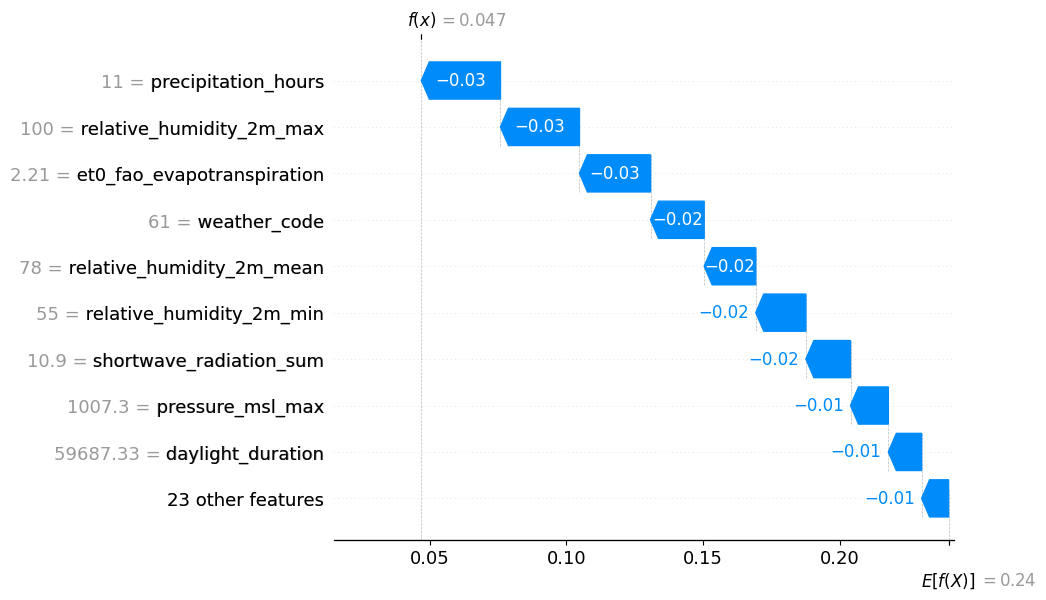

In [ ]:
#FN

def model_proba(X_array):
    X_df = pd.DataFrame(X_array, columns=X_subtrain.columns)
    return stacking_cb_rf.predict_proba(X_df)[:, 1]

background = X_subtrain.sample(100, random_state=42).values
explainer = shap.KernelExplainer(model_proba, background)

idx = fn_hc [0]
x_example = X_val.iloc[[idx]].values

shap_values = explainer.shap_values(x_example, nsamples=200)

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_val.iloc[idx],
        feature_names=X_val.columns
    )
)

## Ложноотрицательный прогноз (False Negative)

Вероятность, присвоенная моделью, составила 0.047, что значительно ниже выбранного порога в 0.172. Это означает, что модель не распознала опасную ситуацию и отнесла её к безопасным. Однако в этой точке пожар произошёл, что делает случай достаточно критичным.

## Наиболее значимые признаки, повлиявшие на это решение:
- **precipitation_hours** `−0.03`  
  длительные осадки значительно понижают прогноз пожара
- **relative_humidity_2m_max** `−0.03`  
  высокая максимальная влажность снижает вероятность возгорания
- **et0_fao_evapotranspiration** `−0.03`  
  низкая испаряемость указывает на влажные условия
- **weather_code** `−0.02`  
  погодный код отражает атмосферные явления, не способствующие пожару
- **relative_humidity_2m_mean** `−0.02`  
  средняя высокая влажность уменьшает пожарную опасность

Модель классифицировала точку как непожароопасную из-за набора факторов, типичных для влажной и прохладной погоды — высокая влажность, продолжительные осадки и низкое испарение. Однако, несмотря на это, пожар всё же произошёл.

## Возможные меры для снижения подобных ложных срабатываний те же, что и при ложноположительных прогнозах.


In [ ]:
!pip install clearml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.9 MB/s eta 0:00:00


In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=24SOI94HSOV7YWNWSPGVUCJD3D8GX6
%env CLEARML_API_SECRET_KEY=bbsjvtiG3XMr3ygNteA2MUw-Dq6kB4gAOY6NTJIH2ceeQIoALhm2uSvP6cTwp-hrt0k

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=24SOI94HSOV7YWNWSPGVUCJD3D8GX6
env: CLEARML_API_SECRET_KEY=bbsjvtiG3XMr3ygNteA2MUw-Dq6kB4gAOY6NTJIH2ceeQIoALhm2uSvP6cTwp-hrt0k


In [ ]:
from clearml import Task

# Инициализация задачи (или прикрепление к существующей)
task = Task.init(
    project_name="Fires",  # имя проекта
    task_name="Upload Stacking CB+RF-LR Model",  # имя задачи
    task_type=Task.TaskTypes.training  # можно оставить как training
)

# Путь к сохранённой модели
model_path = "stacking_cb_rf_model.pkl"

# Загрузка модели как артефакт
task.upload_artifact(
    name="stacking_cb_rf_model.pkl",              # как будет называться в ClearML
    artifact_object=model_path     # путь к файлу
)

print("✅ Модель успешно загружена в ClearML")

task.close()

ClearML Task: created new task id=dbe92eb62ab745de98ba9c5f03b883e8
2025-06-03 13:54:21,574 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/2c7a9822aa8a480aa06c9fb87bbc9e89/experiments/dbe92eb62ab745de98ba9c5f03b883e8/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
✅ Модель успешно загружена в ClearML
2025-06-03 13:54:39,012 - clearml.storage - INFO - Uploading: 87.19MB from /content/stacking_cb_rf_model.pkl


███████████████████████████████ 100% | 87.19/87.19 MB [00:01<00:00, 69.81MB/s]: 


In [ ]:
# Инициализация задачи (или прикрепление к существующей)
task = Task.init(
    project_name="Fires",  # имя проекта
    task_name="Upload Stacking XGB+CB-LR Model",  # имя задачи
    task_type=Task.TaskTypes.training  # можно оставить как training
)

# Путь к сохранённой модели
model_path = "stacking_xgb_cb_model.pkl"

# Загрузка модели как артефакт
task.upload_artifact(
    name="stacking_xgb_cb_model.pkl",              # как будет называться в ClearML
    artifact_object=model_path     # путь к файлу
)

print("✅ Модель успешно загружена в ClearML")

task.close()

ClearML Task: created new task id=b3e2b6cb2ee948258f073909189c7edd
ClearML results page: https://app.clear.ml/projects/2c7a9822aa8a480aa06c9fb87bbc9e89/experiments/b3e2b6cb2ee948258f073909189c7edd/output/log
✅ Модель успешно загружена в ClearML
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


█████████████████████████████████ 100% | 8.95/8.95 MB [00:00<00:00, 38.32MB/s]: 


In [ ]:
!pip freeze

absl-py==1.4.0
accelerate==1.7.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.7
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.5.19.0.38.36
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.4.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.3.3
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
catboost==1.2.8
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.10.0
clearml==2.0.0
click==8.2.1
cloudpathlib==0.21.1
cloudpickle==3.1.1
cmake==3